# Airbnb - Classifying Ratings

## Importing libraries

In [1]:
# For Analysis
import numpy as np
import pandas as pd

# For Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For Calculations
from math import floor

#For Feature Selection
from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectFromModel
from boruta import BorutaPy
from sklearn.preprocessing import MinMaxScaler

#For Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC, SVR, SVC

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.naive_bayes import MultinomialNB as mnb
from sklearn.naive_bayes import BernoulliNB as bnb

# For Validation
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc, f1_score, classification_report, roc_curve

from scipy import interp
from itertools import cycle

# For Storing Models
import pickle
%matplotlib inline

# For Gradient Boosting
import lightgbm as lgb

### Support Functions

Function to identify columns with missing values

In [2]:
def show_cols_with_missing(df):
    missing_vals = df.isnull().sum().sort_values(ascending = False)
    
    return missing_vals.iloc[missing_vals.nonzero()[0]]

Function to build ROC curve for multiclass classification

In [3]:
def plot_roc(y_actual,y_calc,modname):
    t1=sum(x==0 for x in y_calc-y_actual)/len(y_calc)
    n_classes=3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_actual))[:, i], np.array(pd.get_dummies(y_calc))[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    lw=2
    plt.figure(figsize=(8,8))
    plt.plot(fpr["macro"], tpr["macro"],
    label='macro-average ROC curve (area = {0:0.2f})'
          ''.format(roc_auc["macro"]),
    color='green', linestyle=':', linewidth=4)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str('Receiver Operating Characteristics for '+modname))
    plt.legend(loc="lower right")
    plt.show()

Function to calculate Relative classification Error using confusion matrix

In [4]:
def weighted_classification_err(con_mat): 
    err = []
    labs = []
    for i in range(len(con_mat)):
        err.append((con_mat.iloc[i,:].sum() - con_mat.iloc[i,i])/(con_mat.iloc[i,:].sum()))
        labs.append(i)
    return pd.DataFrame(list(zip(labs,err)),columns=['Labels','Relative classification Error'])

## Read in the preprocessed Dataframe

In [5]:
filename = '../data/saved/listings_dtypes.sav'
listings_dtypes = pickle.load(open(filename, 'rb'))

listings = pd.read_csv("../data/saved/preprocessed_listings.csv", dtype= listings_dtypes)

In [6]:
listings.shape

(73923, 108)

In [7]:
#Filter the listings dataframe, removing the PRICE outliers by a selection window between 10$ and 500$/night
listings = listings[listings.price > 10]
listings = listings[listings.price <= 500]

In [8]:
listings.shape

(71468, 108)

In [9]:
#Print the statistics of the sentiment intensity column
listings["sentiment_intensity"].describe()

count    71468.000000
mean         0.831368
std          0.288834
min         -0.953600
25%          0.840200
50%          0.949500
75%          0.979400
max          0.998500
Name: sentiment_intensity, dtype: float64

#### Drop The Records with Missing Values

This needn't be done here. We can do this just before modelling using Impute in sklearn preprocessing if required. Currently put here for prototyping

In [10]:
show_cols_with_missing(listings)

host_response_rate      17195
review_scores_rating    15418
zipcode                   558
amenities                 546
dtype: int64

In [11]:
# Store a copy of the original data 
listings_with_missing = listings.copy()

# Drop the Missing Values
#listings.dropna(inplace = True)

#Print out the counts again
show_cols_with_missing(listings)

host_response_rate      17195
review_scores_rating    15418
zipcode                   558
amenities                 546
dtype: int64

In [12]:
#Drop the index column from the dataframe
listings = listings.drop('Unnamed: 0', axis = 1)
listings.shape

(71468, 107)

### Data Visualization

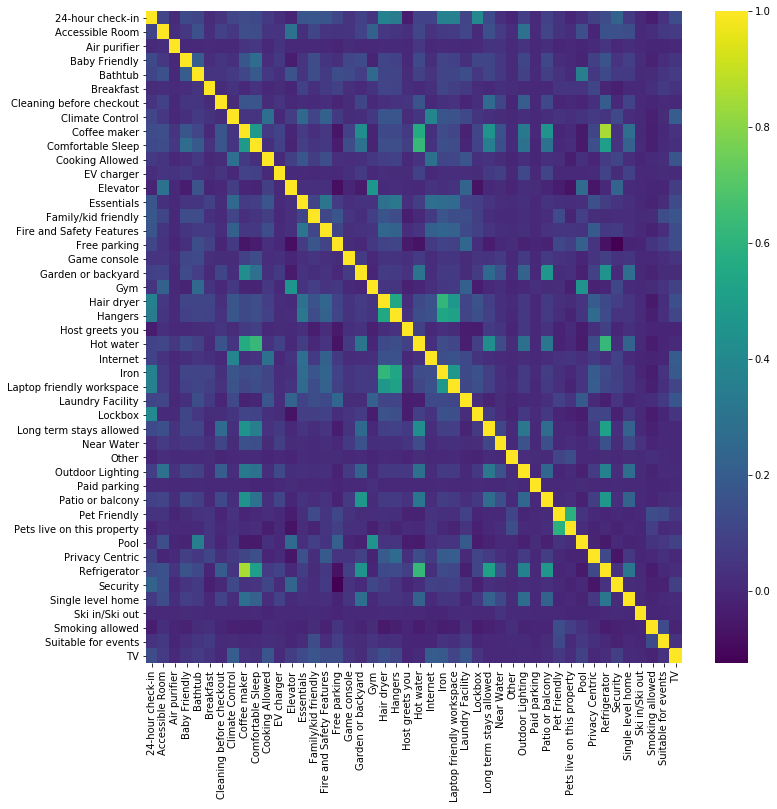

In [13]:
## Generating the heatmap for visualization - using Seaborn
listings_selected_amenities = listings[['24-hour check-in', 'Accessible Room', 'Air purifier',
       'Baby Friendly', 'Bathtub', 'Breakfast', 'Cleaning before checkout',
       'Climate Control', 'Coffee maker', 'Comfortable Sleep',
       'Cooking Allowed', 'EV charger', 'Elevator', 'Essentials',
       'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
       'Game console', 'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers',
       'Host greets you', 'Hot water', 'Internet', 'Iron',
       'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
       'Long term stays allowed', 'Near Water', 'Other', 'Outdoor Lighting',
       'Paid parking', 'Patio or balcony', 'Pet Friendly',
       'Pets live on this property', 'Pool', 'Privacy Centric', 'Refrigerator',
       'Security', 'Single level home', 'Ski in/Ski out', 'Smoking allowed',
       'Suitable for events', 'TV']]
fig = plt.figure(figsize= (12,12))
sns.heatmap(listings_selected_amenities.corr(), annot=False, vmax=1, cmap='viridis', square=False)

### Visualization of target variables

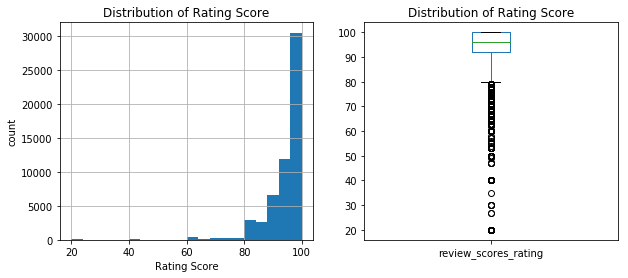

In [14]:
# The Rating score column
fig = plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

listings.review_scores_rating.hist(ax = ax1, bins = 20)
ax1.set_title('Distribution of Rating Score')
ax1.set_xlabel('Rating Score')
ax1.set_ylabel('count')

# The Log Price column
plot = listings.review_scores_rating.plot(kind = 'box', ax = ax2)
ax2.set_title('Distribution of Rating Score')

plt.show()

## Modelling 

### Binning Review Ratings 

In [15]:
#Drop rows with missing values in RATINGS columns
listings_classification = listings.dropna(axis=0, subset = ['review_scores_rating'])
listings_classification.shape

(56050, 107)

We can bin the Review ratings based on 3 approaches
- Based on values
- Based on number of data points in the bins
- Based on Clustering

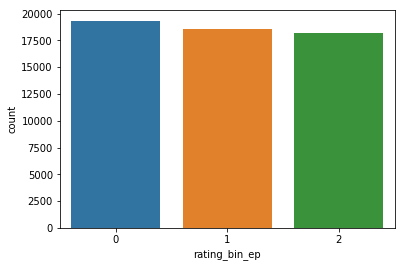

In [16]:
# Create equal probability bins at the PENTILES of RATING
listings_classification = listings_classification.assign(
    rating_bin_ep = pd.qcut(
        listings_classification['review_scores_rating'],
        q=3,
        duplicates='drop',
        #labels=['below_93', '93_to_98', '99_to_100']
        labels=[0,1,2]
    )
)

# Visualize the Split
sns.countplot(listings_classification['rating_bin_ep'])

In [17]:
listings_classification['rating_bin_ep'].value_counts()

0    19330
1    18519
2    18201
Name: rating_bin_ep, dtype: int64

In [18]:
show_cols_with_missing(listings_classification)

host_response_rate    9107
zipcode                404
amenities              186
dtype: int64

In [19]:
listings_classification.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee',
       ...
       'Pool', 'Privacy Centric', 'Refrigerator', 'Security',
       'Single level home', 'Ski in/Ski out', 'Smoking allowed',
       'Suitable for events', 'TV', 'rating_bin_ep'],
      dtype='object', length=108)

In [20]:
# Drop the rows with missing values for particular columns
listings_classification.host_response_rate.fillna(listings_classification.host_response_rate.median(),inplace = True)

### Density of Target against predictors

C:\Users\Manu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


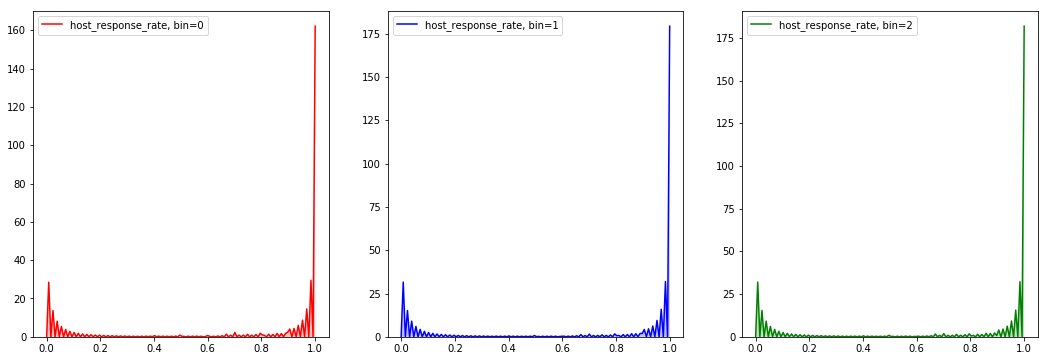

In [21]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.kdeplot(listings_classification.loc[listings_classification['rating_bin_ep'] == 0,'host_response_rate'], shade=True, color="r",label='host_response_rate, bin=0')
plt.subplot(1, 3, 2)
sns.kdeplot(listings_classification.loc[listings_classification['rating_bin_ep'] == 1,'host_response_rate'], shade=True, color="b",label='host_response_rate, bin=1')
plt.subplot(1, 3, 3)
sns.kdeplot(listings_classification.loc[listings_classification['rating_bin_ep'] == 2,'host_response_rate'], shade=True, color="g",label='host_response_rate, bin=2')

plt.show()

C:\Users\Manu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


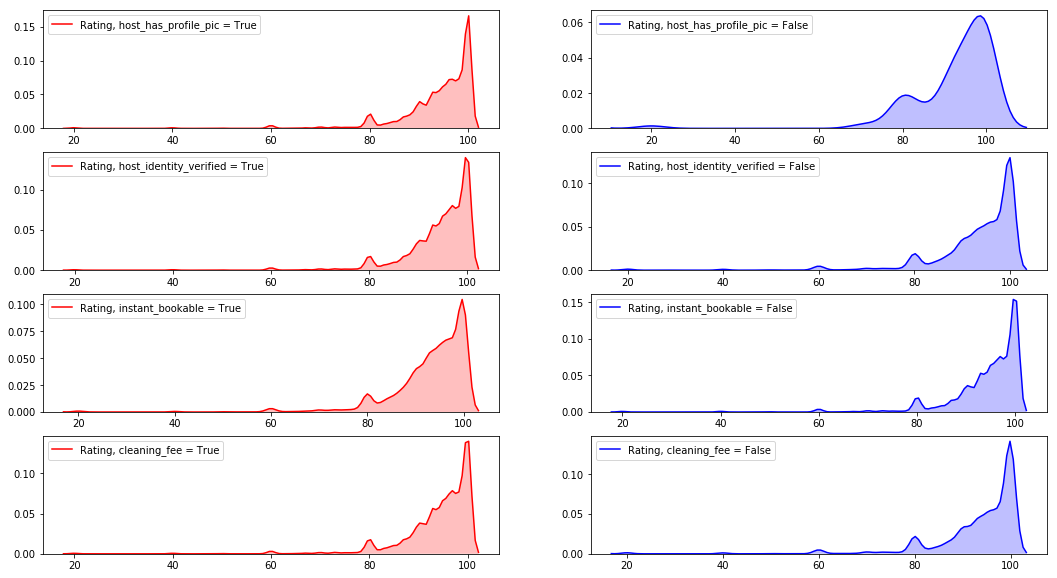

In [22]:
plt.figure(figsize=(18, 10))
plt.subplot(4, 2, 1)
sns.kdeplot(listings_classification.loc[listings_classification['host_has_profile_pic'] == True,'review_scores_rating'], shade=True, color="r",label='Rating, host_has_profile_pic = True')
plt.subplot(4, 2, 2)
sns.kdeplot(listings_classification.loc[listings_classification['host_has_profile_pic'] == False,'review_scores_rating'], shade=True, color="b",label='Rating, host_has_profile_pic = False')

plt.subplot(4, 2, 3)
sns.kdeplot(listings_classification.loc[listings_classification['host_identity_verified'] == True,'review_scores_rating'], shade=True, color="r",label='Rating, host_identity_verified = True')
plt.subplot(4, 2, 4)
sns.kdeplot(listings_classification.loc[listings_classification['host_identity_verified'] == False,'review_scores_rating'], shade=True, color="b",label='Rating, host_identity_verified = False')

plt.subplot(4, 2, 5)
sns.kdeplot(listings_classification.loc[listings_classification['instant_bookable'] == True,'review_scores_rating'], shade=True, color="r",label='Rating, instant_bookable = True')
plt.subplot(4, 2, 6)
sns.kdeplot(listings_classification.loc[listings_classification['instant_bookable'] == False,'review_scores_rating'], shade=True, color="b",label='Rating, instant_bookable = False')

plt.subplot(4, 2, 7)
sns.kdeplot(listings_classification.loc[listings_classification['cleaning_fee'] == True,'review_scores_rating'], shade=True, color="r",label='Rating, cleaning_fee = True')
plt.subplot(4, 2, 8)
sns.kdeplot(listings_classification.loc[listings_classification['cleaning_fee'] == False,'review_scores_rating'], shade=True, color="b",label='Rating, cleaning_fee = False')

plt.show()

### Splitting Test and Train Data


In [23]:
np.random.seed(2018)
train = np.random.choice([True, False], listings_classification.shape[0], replace=True, p=[0.8, 0.2])

listings_classification_train = listings_classification.iloc[train,:]
listings_classification_test = listings_classification.iloc[~train,:]

## Logistic Regression

In [24]:
train_cols = [
    
    'accommodates', 'bathrooms',
    'cleaning_fee',  'host_has_profile_pic',
    'host_identity_verified',  'instant_bookable',
    'thumbnail_url',  'bedrooms', 'beds',
    'dist_to_station',
    'days_since_hosted', 'price',
    'bedroom_share', 'bathroom_share', 'room_type_Entire home/apt',
    'room_type_Private room', 'city_Boston',
    'city_Chicago', 'city_DC', 'city_LA', 'city_NYC', 'city_SF',
    'property_type_Apartment', 'property_type_Condominium',
    'property_type_House', 'property_type_Loft', 'property_type_Townhouse',
    'property_type_other_prop_type', 'bed_type_Real Bed',
    'bed_type_other_bed_type', 'cancellation_policy_flexible',
    'cancellation_policy_moderate', 'cancellation_policy_strict',

    '24-hour check-in', 'Accessible Room', 'Air purifier', 'Baby Friendly',
    'Bathtub', 'Breakfast', 'Cleaning before checkout', 'Climate Control',
    'Coffee maker', 'Comfortable Sleep', 'Cooking Allowed', 'EV charger',
    'Elevator', 'Essentials', 'Family/kid friendly',
    'Fire and Safety Features', 'Free parking', 'Game console',
    'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers', 'Host greets you',
    'Hot water', 'Internet', 'Iron', 'Laptop friendly workspace',
    'Laundry Facility', 'Lockbox', 'Long term stays allowed', 'Near Water',
    'Other', 'Outdoor Lighting', 'Paid parking', 'Patio or balcony',
    'Pet Friendly', 'Pets live on this property', 'Pool', 'Privacy Centric',
    'Refrigerator', 'Security', 'Single level home', 'Ski in/Ski out',
    'Smoking allowed', 'Suitable for events', 'TV'
]


target_col = 'rating_bin_ep'

x_train_logr = listings_classification_train[train_cols]
x_test_logr = listings_classification_test[train_cols]
y_train_logr = listings_classification_train[target_col]
y_test_logr = listings_classification_test[target_col]

print(x_train_logr.shape, x_test_logr.shape, y_train_logr.shape, y_test_logr.shape)

(44853, 79) (11197, 79) (44853,) (11197,)


In [25]:
#Min Max Scaling
scaler = MinMaxScaler()
x_train_logr.loc[:,['accommodates', 'dist_to_station', 'days_since_hosted', 'bedroom_share', 'bathroom_share','price']] = scaler.fit_transform(x_train_logr.loc[:,['accommodates', 'dist_to_station', 'days_since_hosted', 'bedroom_share', 'bathroom_share','price']])
x_test_logr.loc[:,['accommodates', 'dist_to_station', 'days_since_hosted', 'bedroom_share', 'bathroom_share','price']] = scaler.transform(x_test_logr.loc[:,['accommodates', 'dist_to_station', 'days_since_hosted', 'bedroom_share', 'bathroom_share','price']])

C:\Users\Manu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Manu\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Manu\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
#Logistic regression fit and score for different C values
C = [0.01, 0.1, 1, 10]
for i in C:
    logit = LogisticRegression(C=i, random_state=0, solver='newton-cg',multi_class='multinomial')
    logit.fit(x_train_logr, y_train_logr)
    print("\n")
    print("C = ",i)
    print('Train accuracy score:',round(logit.score(x_train_logr, y_train_logr),4))
    print('Test accuracy score:',round(logit.score(x_test_logr, y_test_logr),4))
    



C =  0.01
Train accuracy score: 0.4707
Test accuracy score: 0.4648


C =  0.1
Train accuracy score: 0.4724
Test accuracy score: 0.4649


C =  1
Train accuracy score: 0.4722
Test accuracy score: 0.465


C =  10
Train accuracy score: 0.4719
Test accuracy score: 0.4648


In [27]:
#Logistic Regression model of the best C model
logit_best_fit = LogisticRegression(C=1, random_state=0, solver='newton-cg',multi_class='multinomial')
logit_best_fit.fit(x_train_logr, y_train_logr)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

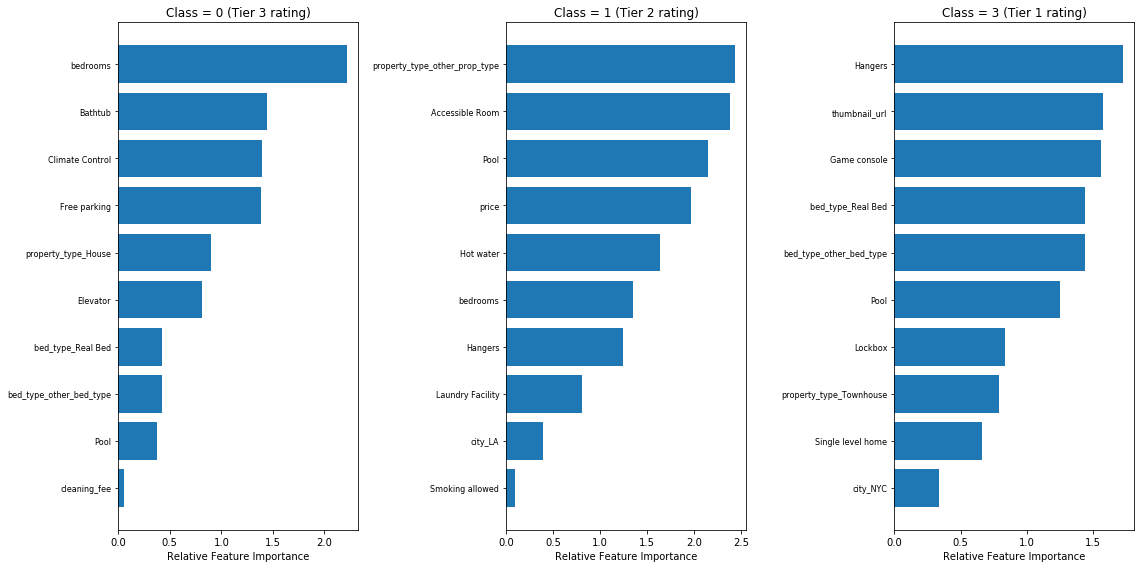

In [28]:
#Plotting Feature Importances from Logistic Regression
featfig = plt.figure(figsize=(16,8))

feature_importance = abs(logit_best_fit.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[0:10]
pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx_list = list(sorted_idx)
featax = featfig.add_subplot(1, 3, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(x_train_logr.columns[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
featax.set_title('Class = 0 (Tier 3 rating)')

feature_importance = abs(logit_best_fit.coef_[1])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[0:10]
pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx_list = list(sorted_idx)
featax = featfig.add_subplot(1, 3, 2)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(x_train_logr.columns[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
featax.set_title('Class = 1 (Tier 2 rating)')

feature_importance = abs(logit_best_fit.coef_[2])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[0:10]
pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx_list = list(sorted_idx)
featax = featfig.add_subplot(1, 3, 3)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(x_train_logr.columns[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
featax.set_title('Class = 3 (Tier 1 rating)')

plt.tight_layout()   
plt.show()

Logistic Regression - Validating results on test dataset
--------------------------------------------------
Score: 0.465
Precision: 0.46 
Recall: 0.47 
F1 Score: 0.46
--------------------------------------------------

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.50      0.49      3908
           1       0.46      0.45      0.46      3736
           2       0.45      0.44      0.45      3553

   micro avg       0.47      0.47      0.47     11197
   macro avg       0.46      0.46      0.46     11197
weighted avg       0.46      0.47      0.46     11197


Logistic Regression - ROC Curve


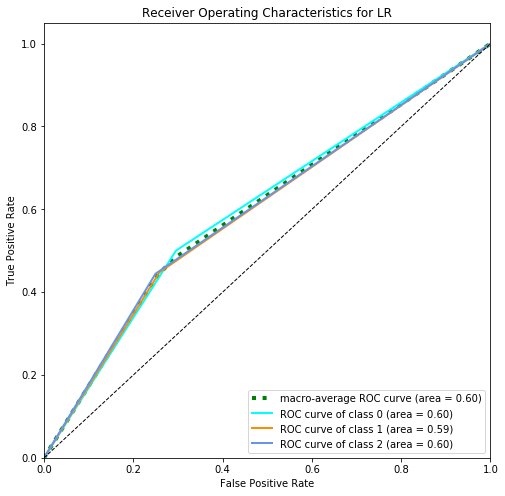


Logistic Regression - Confusion Matrix


,P_Class_0,P_Class_1,P_Class_2
Class_0,1955,980,973
Class_1,1128,1673,935
Class_2,1026,948,1579


In [29]:
# Logistic Regression - Validating results on test dataset
logit_y_predict = logit_best_fit.predict(x_test_logr)

# Print score, precision, recall and f1 measure
print("Logistic Regression - Validating results on test dataset")
print("--------------------------------------------------")
print("Score: %.3f" % logit_best_fit.score(x_test_logr,y_test_logr))
print('Precision: %0.2f \nRecall: %0.2f \nF1 Score: %0.2f' %
      (precision_score(y_test_logr, logit_y_predict, average='weighted'),
       recall_score(y_test_logr, logit_y_predict, average='weighted'),
       f1_score(y_test_logr, logit_y_predict, average='weighted'))
     )
print("--------------------------------------------------")
print("")

# Printing classification_report
print("Classification Report")
print("--------------------------------------------------")
print(classification_report(y_test_logr, logit_y_predict))
print("")

# Plot roc curve
y_test_logr = y_test_logr.ravel()
print("Logistic Regression - ROC Curve")
plot_roc(y_test_logr, logit_y_predict,'LR')
print("")

# Generate confusion matrix
conf_mat_df_logr = pd.DataFrame(data=confusion_matrix(y_test_logr, logit_y_predict), 
                           columns=['P_Class_0', 'P_Class_1', 'P_Class_2'],
                           index=['Class_0', 'Class_1', 'Class_2'])
print("Logistic Regression - Confusion Matrix")
conf_mat_df_logr

In [38]:
logit_y_predict[:10]

array([0, 0, 2, 0, 1, 0, 2, 1, 1, 1], dtype=int64)

In [40]:
print("Log-Loss Error : %0.2f" % log_loss(y_test_logr, logit_best_fit.predict_proba(x_test_logr)))

Log-Loss Error : 1.03


In [41]:
## Calculate Relative classification Error using confusion matrix
weighted_classification_err(conf_mat_df_logr)

,Labels,Relative classification Error
0,0,0.499744
1,1,0.552195
2,2,0.555587


## Decision tree

In [42]:
train_cols = listings_classification.\
    select_dtypes([np.number,bool]).\
    columns.drop(
        ['review_scores_rating', 
         'number_of_reviews',
         'latitude', 
         'longitude',
         'month_of_listing',
         'year_of_listing', 
         'description_length',
         'lda_attractions',
         'dist_to_attr3',
         'dist_to_attr2',
         'lda_transport',
         'lda_amenities',
         'lda_property_desc', 
         'bedrooms', 
         'bathrooms',
         'beds',
         'price'])
target_col = 'rating_bin_ep'

x_train = listings_classification_train[train_cols].values
x_test = listings_classification_test[train_cols].values
y_train = listings_classification_train[target_col].values
y_test = listings_classification_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
           

(44853, 80) (11197, 80) (44853,) (11197,)


In [43]:
show_cols_with_missing(listings_classification_train[train_cols])
#listings_classification_train[train_cols].columns

Series([], dtype: int64)

In [44]:
x_all_RF = listings_classification[train_cols].values
y_all_RF = listings_classification[target_col].values

print(listings_classification.shape, x_all_RF.shape, y_all_RF.shape)

(56050, 108) (56050, 80) (56050,)


Feature importances from Decision Tree


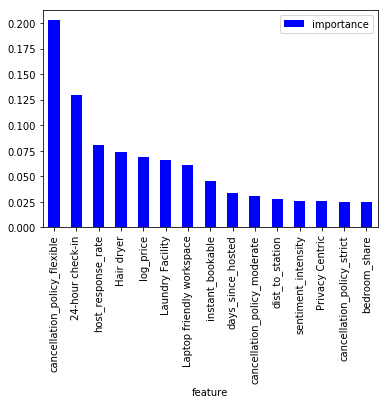

In [45]:
## create the decision tree
dtree = DecisionTreeClassifier(
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
)

dtree.fit(x_train,y_train)
print('Feature importances from Decision Tree')
importances = dtree.feature_importances_
feat_names = train_cols
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:15].plot(x='feature', y='importance', kind='bar',color='blue')

Decision Tree - Validating results on test dataset
--------------------------------------------------
Score: 0.438
Precision: 0.44 
Recall: 0.44 
F1 Score: 0.44
--------------------------------------------------

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.46      0.45      0.45      3908
           1       0.43      0.46      0.44      3736
           2       0.43      0.40      0.42      3553

   micro avg       0.44      0.44      0.44     11197
   macro avg       0.44      0.44      0.44     11197
weighted avg       0.44      0.44      0.44     11197


Decision Tree - ROC Curve


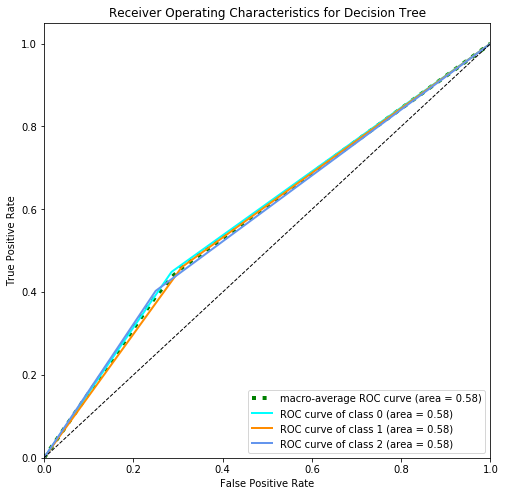


Decision Tree - Confusion Matrix


,P_Class_0,P_Class_1,P_Class_2
Class_0,1754,1123,1031
Class_1,1137,1719,880
Class_2,944,1177,1432


In [46]:
## Decision Tree - Validating results on test dataset
dtree_y_predict = dtree.predict(x_test)

## print score, precision, recall and f1 measure
print("Decision Tree - Validating results on test dataset")
print("--------------------------------------------------")
print("Score: %.3f" % dtree.score(x_test,y_test))
print('Precision: %0.2f \nRecall: %0.2f \nF1 Score: %0.2f' %
      (precision_score(y_test, dtree_y_predict, average='weighted'),
       recall_score(y_test, dtree_y_predict, average='weighted'),
       f1_score(y_test, dtree_y_predict, average='weighted'))
     )
print("--------------------------------------------------")
print("")

## printing classification_report
print("Classification Report")
print("--------------------------------------------------")
print(classification_report(y_test, dtree_y_predict))
print("")

## plot roc curve
y_test = y_test.ravel()
print("Decision Tree - ROC Curve")
plot_roc(y_test, dtree_y_predict,'Decision Tree')
print("")

## generate confusion matrix
conf_mat_df_dt = pd.DataFrame(data=confusion_matrix(y_test, dtree_y_predict), 
                           columns=['P_Class_0', 'P_Class_1', 'P_Class_2'],
                           index=['Class_0', 'Class_1', 'Class_2'])

print("Decision Tree - Confusion Matrix")
conf_mat_df_dt

In [47]:
print("Log-Loss Error : %0.2f" % log_loss(y_test, dtree.predict_proba(x_test)))

Log-Loss Error : 1.06


In [46]:
## Calculate Relative classification Error using confusion matrix
weighted_classification_err(conf_mat_df_dt)

,Labels,Relative classification Error
0,0,0.551177
1,1,0.539882
2,2,0.596960


## Random Forest

Feature importances from Random Forest


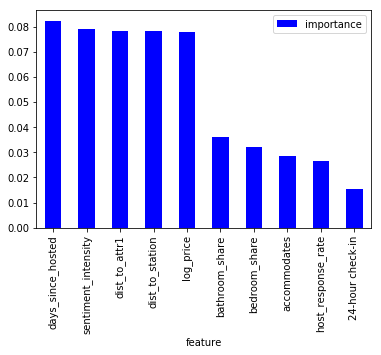

In [50]:
# Random Forest Model
rf = RandomForestClassifier(
    n_estimators=1000, 
    max_depth=30, 
    min_samples_split=10, 
    class_weight="balanced"
    )

rf.fit(x_train, y_train)
print('Feature importances from Random Forest')
importances = rf.feature_importances_
feat_names = train_cols
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar',color='blue')

In [52]:
def select_model(df, features, target = 'rating_bin_ep'):
    all_X = df[features]
    all_y = df[target]
    
    list_estimators = [
        {
            'name' : 'LogisticRegression',
            'estimator' : LogisticRegression(),
            'hyperparameters' : {
                "solver" : ["newton-cg", "lbfgs"]
            }
        }
        
    ]
    
    for estimator in list_estimators:
        print(estimator['name'])
        
        grid = GridSearchCV(estimator['estimator'], param_grid= estimator['hyperparameters'], cv = 5)
        grid.fit(all_X, all_y)
        
        estimator['best_parameter'] = grid.best_params_
        estimator['best_score'] = grid.best_score_
        estimator['best_estimator'] = grid.best_estimator_
        
        print("Best Parameters:",estimator['best_parameter'])
        print("Best Score: %0.2f \n" % estimator['best_score'])
        
    return list_estimators   

Random Forest - Validating results on test dataset
--------------------------------------------------
Score: 0.490
Precision: 0.49 
Recall: 0.49 
F1 Score: 0.49
--------------------------------------------------

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      3908
           1       0.49      0.48      0.48      3736
           2       0.47      0.48      0.47      3553

   micro avg       0.49      0.49      0.49     11197
   macro avg       0.49      0.49      0.49     11197
weighted avg       0.49      0.49      0.49     11197


Random Forest - ROC Curve


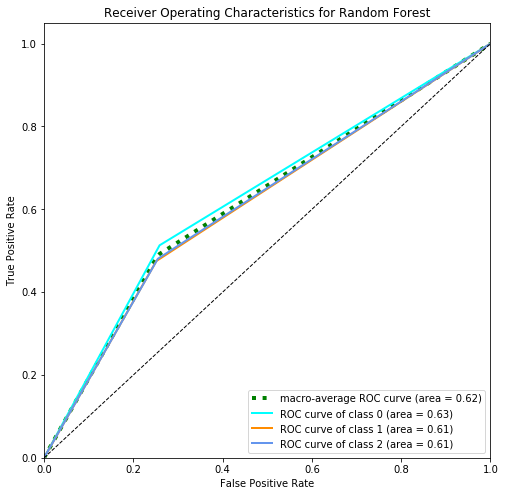


Random Forest - Confusion Matrix


,P_Class_0,P_Class_1,P_Class_2
Class_0,2005,900,1003
Class_1,1017,1775,944
Class_2,869,977,1707


In [53]:
## Random Forest - Validating results on test dataset
rf_y_predict = rf.predict(x_test)

## print score, precision, recall and f1 measure
print("Random Forest - Validating results on test dataset")
print("--------------------------------------------------")
print("Score: %.3f" % rf.score(x_test,y_test))
print('Precision: %0.2f \nRecall: %0.2f \nF1 Score: %0.2f' %
      (precision_score(y_test, rf_y_predict, average='weighted'),
       recall_score(y_test, rf_y_predict, average='weighted'),
       f1_score(y_test, rf_y_predict, average='weighted'))
     )
print("--------------------------------------------------")
print("")

## printing classification_report
print("Classification Report")
print("--------------------------------------------------")
print(classification_report(y_test, rf_y_predict))
print("")

## plot roc curve
y_test = y_test.ravel()
print("Random Forest - ROC Curve")
plot_roc(y_test, rf_y_predict,'Random Forest')
print("")

## generate confusion matrix
conf_mat_df_rf = pd.DataFrame(data=confusion_matrix(y_test, rf_y_predict), 
                           columns=['P_Class_0', 'P_Class_1', 'P_Class_2'],
                           index=['Class_0', 'Class_1', 'Class_2'])
print("Random Forest - Confusion Matrix")
conf_mat_df_rf

In [54]:
print("Log-Loss Error : %0.2f" % log_loss(y_test, rf.predict_proba(x_test)))

Log-Loss Error : 1.01


In [ ]:
## Calculate Relative classification Error using confusion matrix
weighted_classification_err(conf_mat_df_rf)

# Naive Bayes

In [ ]:
train_cols = [
    
    'accommodates', 'bathrooms',
    'cleaning_fee',  'host_has_profile_pic',
    'host_identity_verified',  'instant_bookable',
    'thumbnail_url',  'bedrooms', 'beds',
    'dist_to_station',
    'days_since_hosted', 'price',
    'bedroom_share', 'bathroom_share', 'room_type_Entire home/apt',
    'room_type_Private room', 'city_Boston',
    'city_Chicago', 'city_DC', 'city_LA', 'city_NYC', 'city_SF',
    'property_type_Apartment', 'property_type_Condominium',
    'property_type_House', 'property_type_Loft', 'property_type_Townhouse',
    'property_type_other_prop_type', 'bed_type_Real Bed',
    'bed_type_other_bed_type', 'cancellation_policy_flexible',
    'cancellation_policy_moderate', 'cancellation_policy_strict',

    '24-hour check-in', 'Accessible Room', 'Air purifier', 'Baby Friendly',
    'Bathtub', 'Breakfast', 'Cleaning before checkout', 'Climate Control',
    'Coffee maker', 'Comfortable Sleep', 'Cooking Allowed', 'EV charger',
    'Elevator', 'Essentials', 'Family/kid friendly',
    'Fire and Safety Features', 'Free parking', 'Game console',
    'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers', 'Host greets you',
    'Hot water', 'Internet', 'Iron', 'Laptop friendly workspace',
    'Laundry Facility', 'Lockbox', 'Long term stays allowed', 'Near Water',
    'Other', 'Outdoor Lighting', 'Paid parking', 'Patio or balcony',
    'Pet Friendly', 'Pets live on this property', 'Pool', 'Privacy Centric',
    'Refrigerator', 'Security', 'Single level home', 'Ski in/Ski out',
    'Smoking allowed', 'Suitable for events', 'TV'
]


target_col = 'rating_bin_ep'

x_train_nb = listings_classification_train[train_cols]
x_test_nb = listings_classification_test[train_cols]
y_train_nb = listings_classification_train[target_col]
y_test_nb = listings_classification_test[target_col]

print(x_train_nb.shape, x_test_nb.shape, y_train_nb.shape, y_test_nb.shape)

In [32]:
#Create an unsplit array of predictors and target to perform K fold cross validation
x_all = listings_classification[train_cols].values
y_all = listings_classification[target_col].values

print(listings_classification.shape, x_all.shape, y_all.shape)

(56050, 108) (56050, 79) (56050,)


In [87]:
#Min Max Scaling
scaler = MinMaxScaler()
x_train_nb.loc[:,['accommodates', 'dist_to_station', 'days_since_hosted', 'bedroom_share', 'bathroom_share','price']] = scaler.fit_transform(x_train_nb.loc[:,['accommodates', 'dist_to_station', 'days_since_hosted', 'bedroom_share', 'bathroom_share','price']])
x_test_nb.loc[:,['accommodates', 'dist_to_station', 'days_since_hosted', 'bedroom_share', 'bathroom_share','price']] = scaler.transform(x_test_nb.loc[:,['accommodates', 'dist_to_station', 'days_since_hosted', 'bedroom_share', 'bathroom_share','price']])

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [88]:
#Gaussian Naive Bayes model
clf_gnb = gnb()
print(clf_gnb.fit(x_train_nb, y_train_nb))
print('Gaussian Naive Bayes:')
print('Train score:', clf_gnb.score(x_train_nb, y_train_nb))
print('Test score:', accuracy_score(y_test_nb, clf_gnb.predict(x_test_nb)))

GaussianNB(priors=None, var_smoothing=1e-09)
Gaussian Naive Bayes:
Train score: 0.418634205069895
Test score: 0.4124319014021613


Gaussian Naive Bayes - Validating results on test dataset
--------------------------------------------------
Score: 0.412
Precision: 0.42 
Recall: 0.41 
F1 Score: 0.39
--------------------------------------------------

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.41      0.70      0.52      3908
           1       0.44      0.22      0.30      3736
           2       0.40      0.29      0.34      3553

   micro avg       0.41      0.41      0.41     11197
   macro avg       0.42      0.41      0.38     11197
weighted avg       0.42      0.41      0.39     11197


GNB - ROC Curve


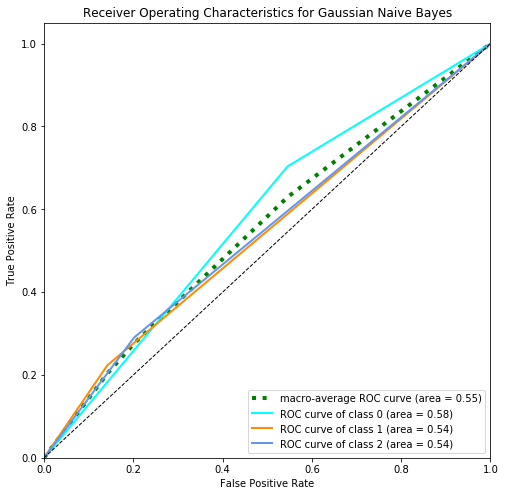


GNB - Confusion Matrix


,P_Class_0,P_Class_1,P_Class_2
Class_0,2749,493,666
Class_1,2022,836,878
Class_2,1953,567,1033


In [89]:
## Gaussian Naive Bayes - Validating results on test dataset
gnb_y_predict = clf_gnb.predict(x_test_nb)

## print score, precision, recall and f1 measure
print("Gaussian Naive Bayes - Validating results on test dataset")
print("--------------------------------------------------")
print("Score: %.3f" % clf_gnb.score(x_test_nb,y_test_nb))
print('Precision: %0.2f \nRecall: %0.2f \nF1 Score: %0.2f' %
      (precision_score(y_test_nb, gnb_y_predict, average='weighted'),
       recall_score(y_test_nb, gnb_y_predict, average='weighted'),
       f1_score(y_test_nb, gnb_y_predict, average='weighted'))
     )
print("--------------------------------------------------")
print("")

## printing classification_report
print("Classification Report")
print("--------------------------------------------------")
print(classification_report(y_test_nb, gnb_y_predict))
print("")

## plot roc curve
y_test_nb = y_test_nb.ravel()
print("GNB - ROC Curve")
plot_roc(y_test_nb, gnb_y_predict,'Gaussian Naive Bayes')
print("")

## generate confusion matrix
conf_mat_df_gnb = pd.DataFrame(data=confusion_matrix(y_test_nb, gnb_y_predict), 
                           columns=['P_Class_0', 'P_Class_1', 'P_Class_2'],
                           index=['Class_0', 'Class_1', 'Class_2'])
print("GNB - Confusion Matrix")
conf_mat_df_gnb

In [90]:
## Calculate Relative classification Error using confusion matrix
weighted_classification_err(conf_mat_df_gnb)

,Labels,Relative classification Error
0,0,0.296571
1,1,0.776231
2,2,0.709260


In [91]:
#Multinomial Naive Bayes model
clf_mnb = mnb()
print(clf_mnb.fit(x_train_nb, y_train_nb))
print('Multinomial Naive Bayes:')
print('Train score:', clf_mnb.score(x_train_nb, y_train_nb))
print('Test score:', accuracy_score(y_test_nb, clf_mnb.predict(x_test_nb)))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Multinomial Naive Bayes:
Train score: 0.44625777539963885
Test score: 0.4422613199964276


Multinominal Naive Bayes - Validating results on test dataset
--------------------------------------------------
Score: 0.442
Precision: 0.44 
Recall: 0.44 
F1 Score: 0.44
--------------------------------------------------

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.45      0.52      0.48      3908
           1       0.44      0.43      0.43      3736
           2       0.44      0.37      0.40      3553

   micro avg       0.44      0.44      0.44     11197
   macro avg       0.44      0.44      0.44     11197
weighted avg       0.44      0.44      0.44     11197


mnb - ROC Curve


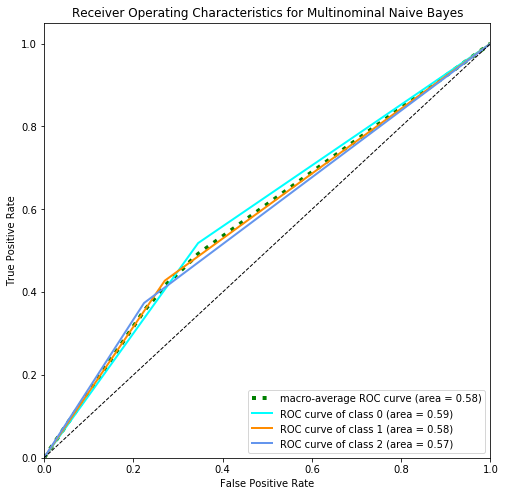


mnb - Confusion Matrix


,P_Class_0,P_Class_1,P_Class_2
Class_0,2026,1008,874
Class_1,1300,1598,838
Class_2,1215,1010,1328


In [92]:
# Multinominal NB - Validating results on test dataset
mnb_y_predict = clf_mnb.predict(x_test_nb)

## print score, precision, recall and f1 measure
print("Multinominal Naive Bayes - Validating results on test dataset")
print("--------------------------------------------------")
print("Score: %.3f" % clf_mnb.score(x_test_nb,y_test_nb))
print('Precision: %0.2f \nRecall: %0.2f \nF1 Score: %0.2f' %
      (precision_score(y_test_nb, mnb_y_predict, average='weighted'),
       recall_score(y_test_nb, mnb_y_predict, average='weighted'),
       f1_score(y_test_nb, mnb_y_predict, average='weighted'))
     )
print("--------------------------------------------------")
print("")

## printing classification_report
print("Classification Report")
print("--------------------------------------------------")
print(classification_report(y_test_nb, mnb_y_predict))
print("")

## plot roc curve
y_test_nb = y_test_nb.ravel()
print("mnb - ROC Curve")
plot_roc(y_test_nb, mnb_y_predict,'Multinominal Naive Bayes')
print("")

## generate confusion matrix
conf_mat_df_mnb = pd.DataFrame(data=confusion_matrix(y_test_nb, mnb_y_predict), 
                           columns=['P_Class_0', 'P_Class_1', 'P_Class_2'],
                           index=['Class_0', 'Class_1', 'Class_2'])
print("mnb - Confusion Matrix")
conf_mat_df_mnb

In [93]:
## Calculate Relative classification Error using confusion matrix
weighted_classification_err(conf_mat_df_mnb)

,Labels,Relative classification Error
0,0,0.481576
1,1,0.572270
2,2,0.626231


In [94]:
#Bernoulli's Naive Bayes model
clf_bnb = bnb(binarize=0.1)
print(clf_bnb.fit(x_train_nb, y_train_nb))
print('Bernoulli Naive Bayes:')
print('Train score:', clf_bnb.score(x_train_nb, y_train_nb))
print('Test score:', accuracy_score(y_test_nb, clf_bnb.predict(x_test_nb)))

BernoulliNB(alpha=1.0, binarize=0.1, class_prior=None, fit_prior=True)
Bernoulli Naive Bayes:
Train score: 0.43769647515216376
Test score: 0.44431544163615255


Bernoulli Naive Bayes - Validating results on test dataset
--------------------------------------------------
Score: 0.444
Precision: 0.44 
Recall: 0.44 
F1 Score: 0.44
--------------------------------------------------

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.45      0.46      0.46      3908
           1       0.44      0.54      0.48      3736
           2       0.44      0.32      0.37      3553

   micro avg       0.44      0.44      0.44     11197
   macro avg       0.44      0.44      0.44     11197
weighted avg       0.44      0.44      0.44     11197


bnb - ROC Curve


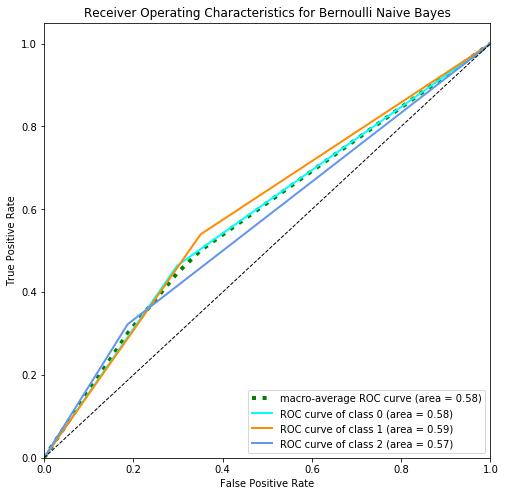


bnb - Confusion Matrix


,P_Class_0,P_Class_1,P_Class_2
Class_0,1813,1344,751
Class_1,1039,2016,681
Class_2,1134,1273,1146


In [95]:
# BernoulliNB - Validating results on test dataset
bnb_y_predict = clf_bnb.predict(x_test_nb)

## print score, precision, recall and f1 measure
print("Bernoulli Naive Bayes - Validating results on test dataset")
print("--------------------------------------------------")
print("Score: %.3f" % clf_bnb.score(x_test_nb,y_test_nb))
print('Precision: %0.2f \nRecall: %0.2f \nF1 Score: %0.2f' %
      (precision_score(y_test_nb, bnb_y_predict, average='weighted'),
       recall_score(y_test_nb, bnb_y_predict, average='weighted'),
       f1_score(y_test_nb, bnb_y_predict, average='weighted'))
     )
print("--------------------------------------------------")
print("")

## printing classification_report
print("Classification Report")
print("--------------------------------------------------")
print(classification_report(y_test_nb, bnb_y_predict))
print("")

## plot roc curve
y_test_nb = y_test_nb.ravel()
print("bnb - ROC Curve")
plot_roc(y_test_nb, bnb_y_predict,'Bernoulli Naive Bayes')
print("")

## generate confusion matrix
conf_mat_df_bnb = pd.DataFrame(data=confusion_matrix(y_test_nb, bnb_y_predict), 
                           columns=['P_Class_0', 'P_Class_1', 'P_Class_2'],
                           index=['Class_0', 'Class_1', 'Class_2'])
print("bnb - Confusion Matrix")
conf_mat_df_bnb

In [96]:
## Calculate Relative classification Error using confusion matrix
weighted_classification_err(conf_mat_df_bnb)

,Labels,Relative classification Error
0,0,0.536080
1,1,0.460385
2,2,0.677456


## SVM - C

In [24]:
train_cols = [
    
    'accommodates', 'bathrooms',
    'cleaning_fee',  'host_has_profile_pic',
    'host_identity_verified',  'instant_bookable',
    'thumbnail_url',  'bedrooms', 'beds',
    'dist_to_station',
    'days_since_hosted', 'price',
    'bedroom_share', 'bathroom_share', 'room_type_Entire home/apt',
    'room_type_Private room', 'city_Boston',
    'city_Chicago', 'city_DC', 'city_LA', 'city_NYC', 'city_SF',
    'property_type_Apartment', 'property_type_Condominium',
    'property_type_House', 'property_type_Loft', 'property_type_Townhouse',
    'property_type_other_prop_type', 'bed_type_Real Bed',
    'bed_type_other_bed_type', 'cancellation_policy_flexible',
    'cancellation_policy_moderate', 'cancellation_policy_strict',

    '24-hour check-in', 'Accessible Room', 'Air purifier', 'Baby Friendly',
    'Bathtub', 'Breakfast', 'Cleaning before checkout', 'Climate Control',
    'Coffee maker', 'Comfortable Sleep', 'Cooking Allowed', 'EV charger',
    'Elevator', 'Essentials', 'Family/kid friendly',
    'Fire and Safety Features', 'Free parking', 'Game console',
    'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers', 'Host greets you',
    'Hot water', 'Internet', 'Iron', 'Laptop friendly workspace',
    'Laundry Facility', 'Lockbox', 'Long term stays allowed', 'Near Water',
    'Other', 'Outdoor Lighting', 'Paid parking', 'Patio or balcony',
    'Pet Friendly', 'Pets live on this property', 'Pool', 'Privacy Centric',
    'Refrigerator', 'Security', 'Single level home', 'Ski in/Ski out',
    'Smoking allowed', 'Suitable for events', 'TV'
]


target_col = 'rating_bin_ep'

x_train = listings_classification_train[train_cols].values
x_test = listings_classification_test[train_cols].values
y_train = listings_classification_train[target_col].values
y_test = listings_classification_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(44853, 79) (11197, 79) (44853,) (11197,)


In [25]:
#Define an SVM Model
svm_clf = SVC(C=.5, kernel='rbf')
svm_clf.fit(x_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [26]:
# save the model to disk
model = svm_clf
filename = '../models/rating_clf/rating_svc_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [27]:
# load the model from disk
filename = '../models/rating_clf/rating_svc_model.sav'
svm_clf = pickle.load(open(filename, 'rb'))

SVM - Validating results on test dataset
--------------------------------------------------
Score: 0.375
Precision: 0.37 
Recall: 0.37 
F1 Score: 0.37
--------------------------------------------------

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.39      0.43      0.41      3908
           1       0.38      0.37      0.37      3736
           2       0.36      0.32      0.34      3553

   micro avg       0.37      0.37      0.37     11197
   macro avg       0.37      0.37      0.37     11197
weighted avg       0.37      0.37      0.37     11197


svm - ROC Curve


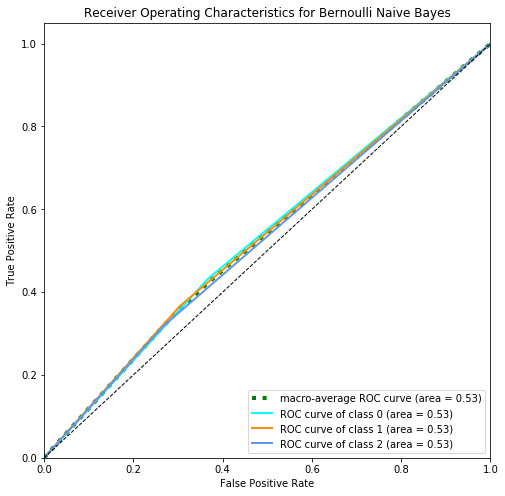


SVM - Confusion Matrix


,P_Class_0,P_Class_1,P_Class_2
Class_0,1691,1163,1054
Class_1,1370,1371,995
Class_2,1309,1111,1133


In [28]:
# SVM C - Validating results on test dataset
svm_y_predict = svm_clf.predict(x_test)

## print score, precision, recall and f1 measure
print("SVM - Validating results on test dataset")
print("--------------------------------------------------")
print("Score: %.3f" % svm_clf.score(x_test,y_test))
print('Precision: %0.2f \nRecall: %0.2f \nF1 Score: %0.2f' %
      (precision_score(y_test, svm_y_predict, average='weighted'),
       recall_score(y_test, svm_y_predict, average='weighted'),
       f1_score(y_test, svm_y_predict, average='weighted'))
     )
print("--------------------------------------------------")
print("")

# printing classification_report
print("Classification Report")
print("--------------------------------------------------")
print(classification_report(y_test, svm_y_predict))
print("")

# plot roc curve
y_test = y_test.ravel()
print("svm - ROC Curve")
plot_roc(y_test, svm_y_predict,'SVM-C')
print("")

# generate confusion matrix
conf_mat_df_svm = pd.DataFrame(data=confusion_matrix(y_test, svm_y_predict), 
                           columns=['P_Class_0', 'P_Class_1', 'P_Class_2'],
                           index=['Class_0', 'Class_1', 'Class_2'])
print("SVM - Confusion Matrix")
conf_mat_df_svm

In [29]:
## Calculate Relative classification Error using confusion matrix
weighted_classification_err(conf_mat_df_svm)

,Labels,Relative classification Error
0,0,0.567298
1,1,0.633030
2,2,0.681115


### LGBM - C

In [105]:
train_cols = [
    
    'accommodates', 'bathrooms',
    'cleaning_fee',  'host_has_profile_pic',
    'host_identity_verified',  'instant_bookable',
    'thumbnail_url',  'bedrooms', 'beds',
    'dist_to_station',
    'days_since_hosted', 'price',
    'bedroom_share', 'bathroom_share', 'room_type_Entire home/apt',
    'room_type_Private room', 'city_Boston',
    'city_Chicago', 'city_DC', 'city_LA', 'city_NYC', 'city_SF',
    'property_type_Apartment', 'property_type_Condominium',
    'property_type_House', 'property_type_Loft', 'property_type_Townhouse',
    'property_type_other_prop_type', 'bed_type_Real Bed',
    'bed_type_other_bed_type', 'cancellation_policy_flexible',
    'cancellation_policy_moderate', 'cancellation_policy_strict',

    '24-hour check-in', 'Accessible Room', 'Air purifier', 'Baby Friendly',
    'Bathtub', 'Breakfast', 'Cleaning before checkout', 'Climate Control',
    'Coffee maker', 'Comfortable Sleep', 'Cooking Allowed', 'EV charger',
    'Elevator', 'Essentials', 'Family/kid friendly',
    'Fire and Safety Features', 'Free parking', 'Game console',
    'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers', 'Host greets you',
    'Hot water', 'Internet', 'Iron', 'Laptop friendly workspace',
    'Laundry Facility', 'Lockbox', 'Long term stays allowed', 'Near Water',
    'Other', 'Outdoor Lighting', 'Paid parking', 'Patio or balcony',
    'Pet Friendly', 'Pets live on this property', 'Pool', 'Privacy Centric',
    'Refrigerator', 'Security', 'Single level home', 'Ski in/Ski out',
    'Smoking allowed', 'Suitable for events', 'TV'
]


target_col = 'rating_bin_ep'

x_train = listings_classification_train[train_cols].values
x_test = listings_classification_test[train_cols].values
y_train = listings_classification_train[target_col].values
y_test = listings_classification_test[target_col].values
y_test = y_test.ravel()
y_train = y_train.ravel()

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(44853, 79) (11197, 79) (44853,) (11197,)


In [106]:
#Create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

#Config the LGBM model parameters
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 17,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 17
         }


print('Training:')
# train

evals_result = {}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=5,
               evals_result=evals_result,
               feature_name=train_cols)

#Save the fit model to a file
gbm.save_model('lgbm_model.txt')

Training:
[1]	valid_0's multi_logloss: 1.09598
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 1.09374
[3]	valid_0's multi_logloss: 1.09172
[4]	valid_0's multi_logloss: 1.09002
[5]	valid_0's multi_logloss: 1.08783
[6]	valid_0's multi_logloss: 1.08615
[7]	valid_0's multi_logloss: 1.08426
[8]	valid_0's multi_logloss: 1.08251
[9]	valid_0's multi_logloss: 1.08108
[10]	valid_0's multi_logloss: 1.07913
[11]	valid_0's multi_logloss: 1.07752
[12]	valid_0's multi_logloss: 1.07642
[13]	valid_0's multi_logloss: 1.07499
[14]	valid_0's multi_logloss: 1.07367
[15]	valid_0's multi_logloss: 1.07228
[16]	valid_0's multi_logloss: 1.07089
[17]	valid_0's multi_logloss: 1.0696
[18]	valid_0's multi_logloss: 1.06826
[19]	valid_0's multi_logloss: 1.06707
[20]	valid_0's multi_logloss: 1.06578
[21]	valid_0's multi_logloss: 1.0646
[22]	valid_0's multi_logloss: 1.06364
[23]	valid_0's multi_logloss: 1.06261
[24]	valid_0's multi_logloss: 1.06139
[25]	valid_0's multi_logloss


LGBM feature importances:


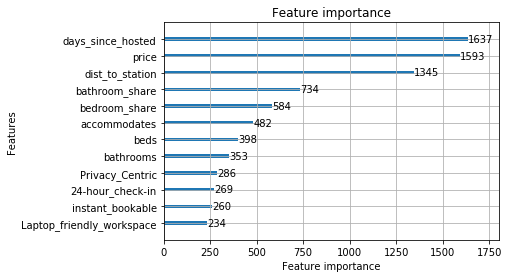

In [107]:
print('\nLGBM feature importances:')
ax = lgb.plot_importance(gbm, max_num_features=12)
plt.show()

Predicting: 

LGBM - Validating results on test dataset
--------------------------------------------------
Precision: 0.48 
Recall: 0.48 
F1 Score: 0.48
--------------------------------------------------

Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      3908
           1       0.48      0.47      0.47      3736
           2       0.47      0.46      0.46      3553

   micro avg       0.48      0.48      0.48     11197
   macro avg       0.48      0.48      0.48     11197
weighted avg       0.48      0.48      0.48     11197


LGBM - ROC Curve


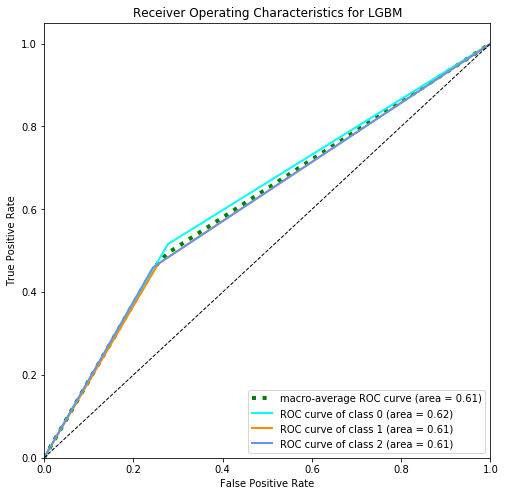


LGBM - Confusion Matrix


,P_Class_0,P_Class_1,P_Class_2
Class_0,2016,937,955
Class_1,1074,1751,911
Class_2,947,972,1634


In [108]:
print('Predicting: \n')

#Predict
y_pred_prob = gbm.predict(x_test, num_iteration=gbm.best_iteration)
lgbm_y_predict = []
for x in y_pred_prob:
    lgbm_y_predict.append(np.argmax(x))

## print score, precision, recall and f1 measure
print("LGBM - Validating results on test dataset")
print("--------------------------------------------------")
#print("Score: %.3f" % gbm.score(x_test,y_test))
print('Precision: %0.2f \nRecall: %0.2f \nF1 Score: %0.2f' %
      (precision_score(y_test, lgbm_y_predict, average='weighted'),
       recall_score(y_test, lgbm_y_predict, average='weighted'),
       f1_score(y_test, lgbm_y_predict, average='weighted'))
     )
print("--------------------------------------------------")
print("")

# printing classification_report
print("Classification Report")
print("--------------------------------------------------")
print(classification_report(y_test, lgbm_y_predict))
print("")

# plot roc curve
y_test = y_test.ravel()
print("LGBM - ROC Curve")
plot_roc(y_test, lgbm_y_predict,'LGBM')
print("")

# generate confusion matrix
conf_mat_df_LGBM = pd.DataFrame(data=confusion_matrix(y_test, lgbm_y_predict), 
                           columns=['P_Class_0', 'P_Class_1', 'P_Class_2'],
                           index=['Class_0', 'Class_1', 'Class_2'])
print("LGBM - Confusion Matrix")
conf_mat_df_LGBM

In [109]:
## Calculate Relative classification Error using confusion matrix
weighted_classification_err(conf_mat_df_LGBM)

,Labels,Relative classification Error
0,0,0.484135
1,1,0.531317
2,2,0.540107


## Model Selection - K fold cross validation

In [110]:
# Calculating cross validation for 5 folds
y_all = y_all.ravel()
y_all_RF = y_all_RF.ravel()

logit_best_fit.fit(x_all, y_all)
logit_best_fit_crossval_scores = cross_val_score(logit_best_fit, x_all, y_all, cv = 5)
logit_best_fit_crossval_scores = [round(i,4) for i in logit_best_fit_crossval_scores]
accuracy_logit_best_fit = round(sum(logit_best_fit_crossval_scores)/5,4)
print("\nLogistic Regression - Cross-Validation for 5 folds")
print("Foldwise scores: ", logit_best_fit_crossval_scores, 
      "\nAverage score: ", accuracy_logit_best_fit)

print("\nGNB - Cross-Validation for 5 folds")
clf_gnb.fit(x_all, y_all)
clf_gnb_crossval_scores = cross_val_score(clf_gnb, x_all, y_all, cv = 5)
clf_gnb_crossval_scores = [round(i,4) for i in clf_gnb_crossval_scores]
accuracy_clf_gnb = round(sum(clf_gnb_crossval_scores)/5,4)
print("Foldwise scores: ", clf_gnb_crossval_scores, 
      "\nAverage score: ", accuracy_clf_gnb)

print("\nMNB - Cross-Validation for 5 folds")
clf_mnb.fit(x_all, y_all)
clf_mnb_crossval_scores = cross_val_score(clf_mnb, x_all, y_all, cv = 5)
clf_mnb_crossval_scores = [round(i,4) for i in clf_mnb_crossval_scores]
accuracy_clf_mnb = round(sum(clf_mnb_crossval_scores)/5,4)
print("Foldwise scores: ", clf_mnb_crossval_scores, 
      "\nAverage score: ", accuracy_clf_mnb)

print("\nBNB - Cross-Validation for 5 folds")
clf_bnb.fit(x_all, y_all)
clf_bnb_crossval_scores = cross_val_score(clf_bnb, x_all, y_all, cv = 5)
clf_bnb_crossval_scores = [round(i,4) for i in clf_bnb_crossval_scores]
accuracy_clf_bnb = round(sum(clf_bnb_crossval_scores)/5,4)
print("Foldwise scores: ", clf_bnb_crossval_scores, 
      "\nAverage score: ", accuracy_clf_bnb)

print("\nSVM - Cross-Validation for 5 folds")
clf_svm.fit(x_all, y_all)
clf_svm_crossval_scores = cross_val_score(clf_svm, x_all, y_all, cv = 5)
clf_svm_crossval_scores = [round(i,4) for i in clf_svm_crossval_scores]
accuracy_clf_svm = round(sum(clf_svm_crossval_scores)/5,4)
print("Foldwise scores: ", clf_svm_crossval_scores, 
      "Average score: ", accuracy_clf_svm)

print("\nDecision Tree - Cross-Validation for 5 folds")
dtree.fit(x_all_RF, y_all_RF)
dtree_crossval_scores = cross_val_score(dtree, x_all_RF, y_all_RF, cv = 5)
dtree_crossval_scores = [round(i,4) for i in dtree_crossval_scores]
accuracy_dtree = round(sum(dtree_crossval_scores)/5,4)
print("Foldwise scores: : ", dtree_crossval_scores, 
      "\nAverage score: ", accuracy_dtree)

print("\nRF - Cross-Validation for 5 folds")
rf.fit(x_all_RF, y_all_RF)
rf_crossval_scores = cross_val_score(rf, x_all_RF, y_all_RF, cv = 5)
rf_crossval_scores = [round(i,4) for i in rf_crossval_scores]
accuracy_rf = round(sum(rf_crossval_scores)/5,4)
print("Foldwise scores: ", rf_crossval_scores, 
      "\nAverage score: ", accuracy_rf)

C:\Users\User\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\User\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\User\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning


Logistic Regression - Cross-Validation for 5 folds
Foldwise scores:  [0.4678, 0.4681, 0.4697, 0.4702, 0.4651] 
Average score:  0.4682

GNB - Cross-Validation for 5 folds
Foldwise scores:  [0.4217, 0.426, 0.4178, 0.4109, 0.4181] 
Average score:  0.4189

MNB - Cross-Validation for 5 folds
Foldwise scores:  [0.3955, 0.3842, 0.3971, 0.3837, 0.3841] 
Average score:  0.3889

BNB - Cross-Validation for 5 folds
Foldwise scores:  [0.4369, 0.4351, 0.4409, 0.4348, 0.4401] 
Average score:  0.4376

Decision Tree - Cross-Validation for 5 folds
Foldwise scores: :  [0.4432, 0.4385, 0.4443, 0.437, 0.4423] 
Average score:  0.4411

RF - Cross-Validation for 5 folds
Foldwise scores:  [0.4963, 0.4931, 0.4919, 0.4895, 0.4909] 
Average score:  0.4923


In [ ]:
y_all = y_all.ravel()
print("\nSVM - Cross-Validation for 5 folds")
svm_clf.fit(x_all, y_all)
clf_svm_crossval_scores = cross_val_score(svm_clf, x_all, y_all, cv = 5)
clf_svm_crossval_scores = [round(i,4) for i in clf_svm_crossval_scores]
accuracy_clf_svm = round(sum(clf_svm_crossval_scores)/5,4)
print("Foldwise scores: ", clf_svm_crossval_scores, 
      "Average score: ", accuracy_clf_svm)


SVM - Cross-Validation for 5 folds


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: 